In [4]:
import numpy as np
import pandas as pd
import scipy
import scipy.constants as cst
import scipy.special as spc
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
import qutip
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',
             fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [5]:
lamda = 1260*10**(-9) #wavelength in nm
k_lamda=2*np.pi/lamda
m_Rb=1.44316*10**(-25) #in kg
Er=(cst.hbar*k_lamda)**2/(2*m_Rb)/cst.h/10**3 #in kHz
print(Er)
V0=8.0
scatterlength=103.*cst.physical_constants['Bohr radius'][0]

1.4460071928883753


# Calculate the evolution of K-D scattering with qutip.mesolve

In [6]:
def ham(V0,q=0,bandnum=11):
    s=(2*np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)+q)**2+0.5*V0
    hamiltonian=np.diag([-0.25*V0]*(bandnum-1),-1)+np.diag([-0.25*V0]*(bandnum-1),1)+np.diag(s)
    return qutip.Qobj(hamiltonian)

In [7]:
bandnum=11
V0=10
tlist=np.linspace(0, 40, 500)

initialstate=np.zeros(bandnum)
initialstate.put(int((bandnum-1)/2),1)
initialstate=initialstate/np.sqrt(np.sum(initialstate**2))
initialstate=qutip.Qobj(initialstate)

results=qutip.mesolve(ham(V0,bandnum=bandnum), initialstate, tlist*2*np.pi*10**-3*Er, [],options=qutip.Options(nsteps=10000))

finalstates=results.states

In [8]:
picd=[]
for everystate in finalstates:
    s=np.abs(everystate.full())**2
    picd.append(s.reshape((bandnum,)))
picd=np.array(picd)

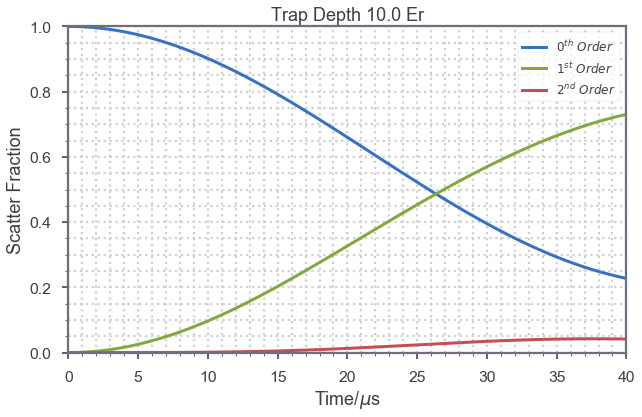

In [9]:
plt.figure(figsize=((10,6)))
plt.title('Trap Depth %0.1f Er'%V0)
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.xlim((0,40))
plt.ylim((0,1))
plt.xlabel('Time/$\mu$s')
plt.ylabel('Scatter Fraction')
plt.plot(tlist,picd[:,int((bandnum-1)/2)],label='$0^{th}\\ Order$',linewidth=3)
plt.plot(tlist,picd[:,int((bandnum-1)/2+1)]+picd[:,int((bandnum-1)/2-1)],label='$1^{st}\\ Order$',linewidth=3)
plt.plot(tlist,picd[:,int((bandnum-1)/2+2)]+picd[:,int((bandnum-1)/2-2)],label='$2^{nd}\\ Order$',linewidth=3)
plt.legend(loc='best',fontsize=12)

In [17]:
bandnum=11

initialstate=np.zeros(bandnum)
initialstate.put(int((bandnum-1)/2),1)
initialstate=initialstate/np.sqrt(np.sum(initialstate**2))
initialstate=qutip.Qobj(initialstate)

ti=20
vlist=np.linspace(0,50,100)
tlist1=np.linspace(0,ti,2)

zero=[]
first=[]
second=[]

for v in vlist:
    results=qutip.mesolve(ham(v,bandnum=bandnum), initialstate, tlist1*2*np.pi*10**-3*Er, [],options=qutip.Options(nsteps=10000))
    s=np.abs(results.states[1].full())**2
    zero.append(s[int((bandnum-1)/2)])
    first.append(s[int((bandnum-1)/2-1)]+s[int((bandnum-1)/2+1)])
    second.append(s[int((bandnum-1)/2-2)]+s[int((bandnum-1)/2+2)])
    #print(results.states)

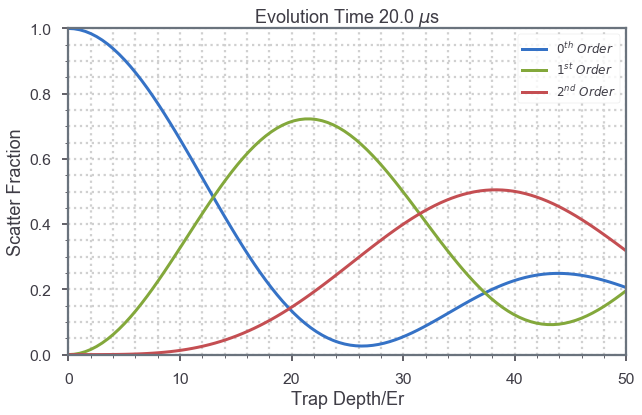

In [18]:
plt.figure(figsize=((10,6)))
plt.title('Evolution Time %0.1f $\mu$s'%ti)
plt.xlim((0,50))
plt.ylim((0,1))
#plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.xlabel('Trap Depth/Er')
plt.ylabel('Scatter Fraction')
plt.plot(vlist,zero,label='$0^{th}\\ Order$',linewidth=3)
plt.plot(vlist,first,label='$1^{st}\\ Order$',linewidth=3)
plt.plot(vlist,second,label='$2^{nd}\\ Order$',linewidth=3)
plt.legend(loc='upper right',fontsize=12)
#plt.scatter(vlist[18],zero[18],marker='o')

# Calculate evolution of K-D scattering directly with $e^{iHt/\hbar}\psi$

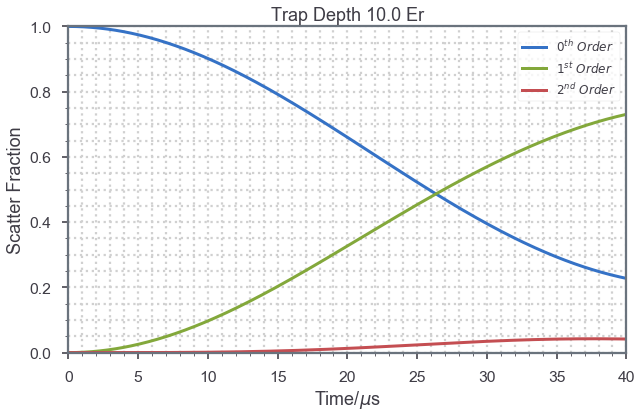

In [12]:
bandnum=11

initialstate1=np.zeros(bandnum)
initialstate1.put(int((bandnum-1)/2),1)
initialstate1=initialstate1/np.sqrt(np.sum(initialstate1**2))
initialstate1=initialstate1.reshape((bandnum,1))
#print(initialstate1)

V0=10
q=0

s=(2*np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)+q)**2+0.5*V0
hamiltonian=np.diag([-0.25*V0]*(bandnum-1),-1)+np.diag([-0.25*V0]*(bandnum-1),1)+np.diag(s)

tlist2=np.linspace(0, 40, 500)
t1=tlist2[1]-tlist2[0]
states=initialstate1
zeros1=[np.abs(states[int(bandnum/2-0.5)])**2]
first1=[np.abs(states[int(bandnum/2-0.5)-1])**2+np.abs(states[int(bandnum/2-0.5)+1])**2]
second1=[np.abs(states[int(bandnum/2-0.5)-2])**2+np.abs(states[int(bandnum/2-0.5)+2])**2]

for i in range(len(tlist2)-1):
    states=np.dot(scipy.linalg.expm(-1j*hamiltonian*t1*Er*10**-3*2*np.pi),states)
    zeros1.append(np.abs(states[int(bandnum/2-0.5)])**2)
    first1.append(np.abs(states[int(bandnum/2-0.5)-1])**2+np.abs(states[int(bandnum/2-0.5)+1])**2)
    second1.append(np.abs(states[int(bandnum/2-0.5)-2])**2+np.abs(states[int(bandnum/2-0.5)+2])**2)

plt.figure(figsize=((10,6)))
plt.title('Trap Depth %0.1f Er'%V0)
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.xlim((0,40))
plt.ylim((0,1))
plt.xlabel('Time/$\mu$s')
plt.ylabel('Scatter Fraction')
plt.plot(tlist2,zeros1,label='$0^{th}\\ Order$',linewidth=3)
plt.plot(tlist2,first1,label='$1^{st}\\ Order$',linewidth=3)
plt.plot(tlist2,second1,label='$2^{nd}\\ Order$',linewidth=3)
plt.legend(loc='upper right',fontsize=12)

In [13]:
bandnum=11
q=0

initialstate1=np.zeros(bandnum)
initialstate1.put(int((bandnum-1)/2),1)
initialstate1=initialstate1/np.sqrt(np.sum(initialstate1**2))

vlist=np.linspace(0,50,100)
ti=30

zero1=[]
first1=[]
second1=[]

for v in vlist:
    st=(2*np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)+q)**2+0.5*v
    hamiltonian=np.diag([-0.25*v]*(bandnum-1),-1)+np.diag([-0.25*v]*(bandnum-1),1)+np.diag(st)
    s1=np.dot(scipy.linalg.expm(-1j*hamiltonian*ti*Er*10**-3*2*np.pi),initialstate1)
    s1=np.abs(s1)**2
    zero1.append(s1[int((bandnum-1)/2)])
    first1.append(s1[int((bandnum-1)/2-1)]+s1[int((bandnum-1)/2+1)])
    second1.append(s1[int((bandnum-1)/2-2)]+s1[int((bandnum-1)/2+2)])
    #print(results.states)

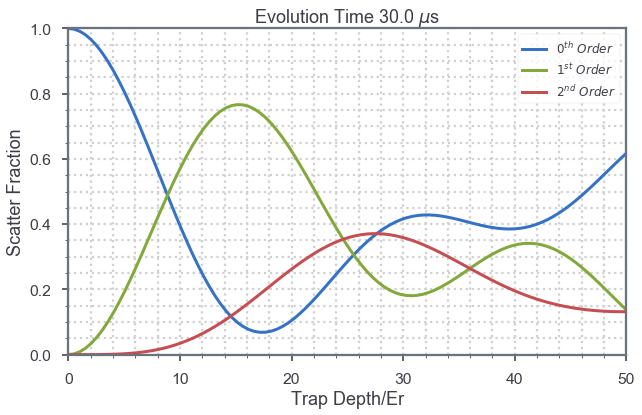

In [14]:
plt.figure(figsize=((10,6)))
plt.title('Evolution Time %0.1f $\mu$s'%ti)
plt.xlim((0,50))
plt.ylim((0,1))
#plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.xlabel('Trap Depth/Er')
plt.ylabel('Scatter Fraction')
plt.plot(vlist,zero1,label='$0^{th}\\ Order$',linewidth=3)
plt.plot(vlist,first1,label='$1^{st}\\ Order$',linewidth=3)
plt.plot(vlist,second1,label='$2^{nd}\\ Order$',linewidth=3)
plt.legend(loc='upper right',fontsize=12)
#plt.scatter(vlist[18],zero[18],marker='o')

In [1]:
import numpy as np
s=[[1,2],[3,4]]
np.dot(s,s)

array([[ 7, 10],
       [15, 22]])

TypeError: can't multiply sequence by non-int of type 'list'